In [1]:
# prvotni import

import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import sys
from numpy import pi
from typing import Tuple, Dict
sys.path.append('..')

In [2]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# konstanty (parametry problemu)
ALPHA = 1.14
A = 2
B = 2
T_MAX = 0.01

In [6]:
l_bounds = [0, 0, 0]
u_bounds = [A, B, T_MAX]

plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    patches=[],
    colour_map='inferno',
    vmin=-3,
    vmax=4,
    device=device,
    N=100
)

In [7]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) - 3 * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B)

def analytical_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) * torch.exp(-ALPHA * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2)) +\
           (-3) * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B) * torch.exp(-ALPHA * 25 * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2))

In [8]:
# moznost dale rozvijet tento zpusob sbirani loss?

pde_loss_values = []
initial_loss_values = []
boundary_loss_values = []
iteration = 0

def pde_residuum(pde_input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    # PDE ztrata:
    pde_output = model(pde_input)
    u_t = grad(pde_output, pde_input, torch.ones_like(pde_output), create_graph=True)[0][:, -1:]
    laplacian = calc.laplacian(pde_input, pde_output, device=device)
    return u_t - ALPHA * laplacian

first_iteration = True
temp_init_condition = lambda x: initial_condition(x)

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # PDE ztrata:
    pde_input = domain.interior.requires_grad_(True)
    pde_res = pde_residuum(pde_input, model)
    pde_loss = torch.mean((pde_res)**2)
    
    # ztrata na hranicich:
    side_input = domain.get_side_points(2).requires_grad_(True)
    side_output = model(side_input)
    side_loss = torch.mean(side_output**2)
    
    # ztrata na pocatku
    initial_input = domain.sides[-1][0].requires_grad_(True)
    init_output = model(initial_input)
    init_values = temp_init_condition(initial_input)
    init_loss = torch.mean((init_output - init_values)**2)

    # valid???
    global iteration
    if iteration % 100 == 99:
        pde_loss_values.append(pde_loss.item())
        boundary_loss_values.append(side_loss.item())
        initial_loss_values.append(init_loss.item())

    iteration += 1
    return [pde_loss, 100 * side_loss, 1000 * init_loss]


In [9]:
# priprava modelu
model_ctx = mm.ModelContext(
    input_dim=3,
    output_dim=1,
    layer=[64, 64, 64],
    l_bounds=l_bounds,
    u_bounds=u_bounds,
)

model_time_dict: Dict[torch.nn.Module, Tuple] = {
    mm.MLPModel(model_ctx).to(device) : (0, 0.0001),
    mm.MLPModel(model_ctx).to(device) : (0.0001, 0.0002),
    mm.MLPModel(model_ctx).to(device) : (0.0002, 0.0004),
    mm.MLPModel(model_ctx).to(device) : (0.0004, 0.0008),
    mm.MLPModel(model_ctx).to(device) : (0.0008, 0.001),
    mm.MLPModel(model_ctx).to(device) : (0.001, 0.002),
    mm.MLPModel(model_ctx).to(device) : (0.002, 0.005),
    mm.MLPModel(model_ctx).to(device) : (0.005, 0.01)
}

In [10]:
# definice domeny
domain_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    dim=3,
    N_int=2_000,
    N_sides=[(100, 100), (100, 100), (1_000, 100)],
    device=device
)

domain = cb.CubeDomain(domain_ctx)

In [11]:
train_ctx = train.TrainingContext(
    domain=domain,
    epochs=4000,
    loss_fn=loss_fn,
    monitor_lr=True,
    monitor_gradient=True,
)

total_loss_values = []
component_loss_values = [[], [], []]  # [pde_loss, init_loss, boundary_loss]

for i, (model, time) in enumerate(model_time_dict.items()):
    train_ctx.model = model
    train_ctx.optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

    domain.ctx.l_bounds[-1] = time[0]
    domain.ctx.u_bounds[-1] = time[1]

    tot_loss_values, com_loss_values = train.train_switch_to_lbfgs(train_ctx, epochs_with_lbfgs=500, lbfgs_lr=0.1)

    for i, component in enumerate(com_loss_values):
        component_loss_values[i] += component

    total_loss_values += tot_loss_values
    prev_model = model
    temp_init_condition = lambda x: prev_model(x)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at epoch 1 is: 2640.250244140625. Total gradient norm: 2926.5704897734954 Current learing rate: 0.003 
Loss at epoch 100 is: 2332.1708984375. Total gradient norm: 97.4036126526189 Current learing rate: 0.003 
Loss at epoch 200 is: 2145.396728515625. Total gradient norm: 98.58614408792546 Current learing rate: 0.003 
Loss at epoch 300 is: 2179.657958984375. Total gradient norm: 67.43351247971538 Current learing rate: 0.003 
Loss at epoch 400 is: 2168.87353515625. Total gradient norm: 51.30501068239807 Current learing rate: 0.003 
Loss at epoch 500 is: 1629.909423828125. Total gradient norm: 1141.2122534441166 Current learing rate: 0.003 
Loss at epoch 600 is: 1470.45361328125. Total gradient norm: 1388.7157294219169 Current learing rate: 0.003 
Loss at epoch 700 is: 1252.390625. Total gradient norm: 1374.433762633716 Current learing rate: 0.003 
Loss at epoch 800 is: 1431.8193359375. Total gradient norm: 14463.513588913978 Current learing rate: 0.003 
Loss at epoch 900 is: 844.7261

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


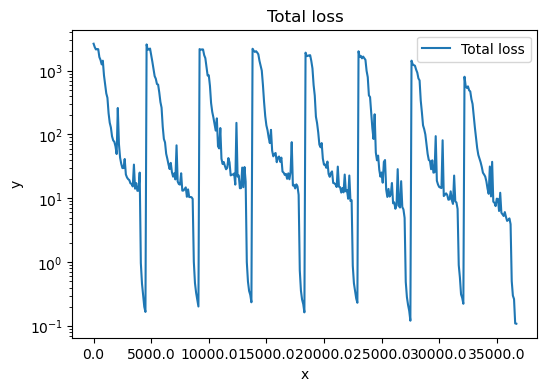

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


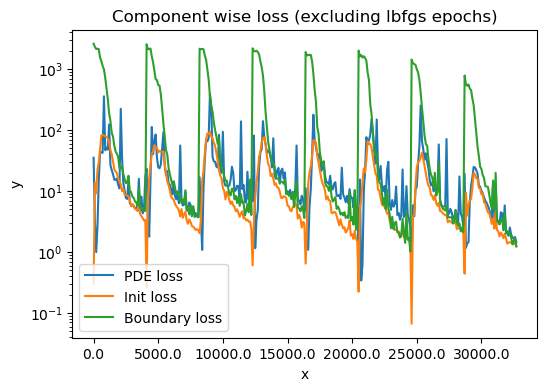

In [12]:
#initial_loss_values = [val.item() for val in initial_loss_values]

#utils.plot_loss_values(pde_loss_values, plot_ctx)
plot_ctx.titles = ['Total loss']
utils.plot_loss_values({'Total loss': total_loss_values}, plot_ctx)
plot_ctx.titles = ['Component wise loss (excluding lbfgs epochs)']
utils.plot_loss_values({'PDE loss' : component_loss_values[0], 'Init loss' : component_loss_values[1], 'Boundary loss' : component_loss_values[2]}, plot_ctx)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


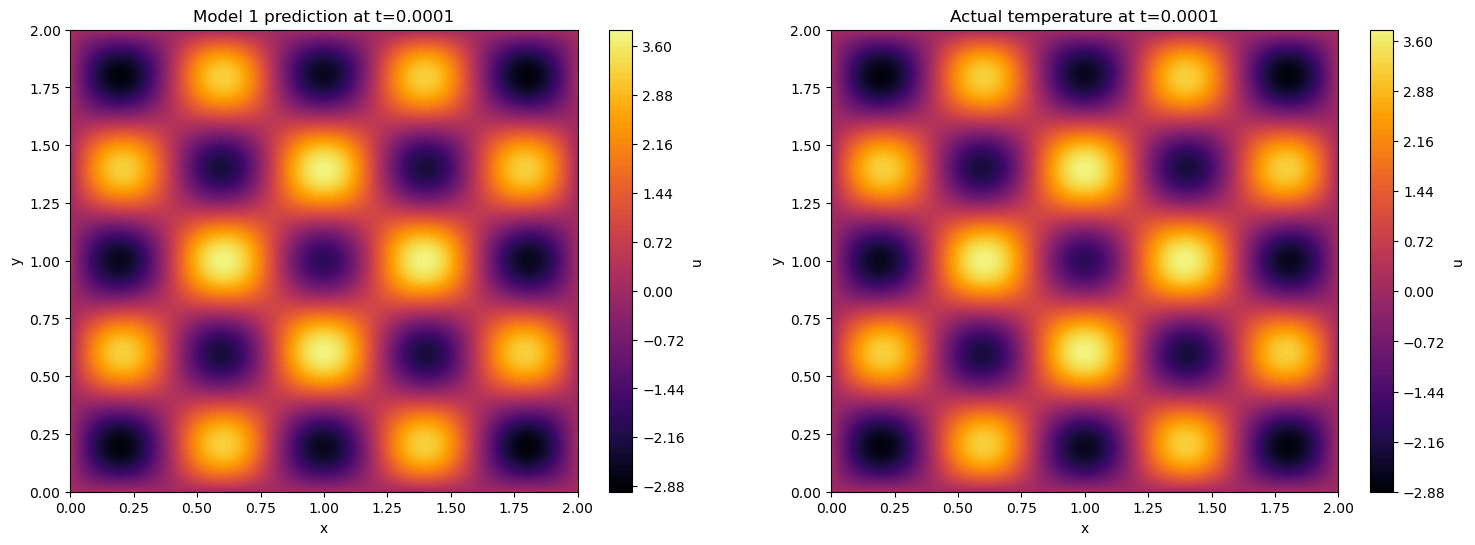

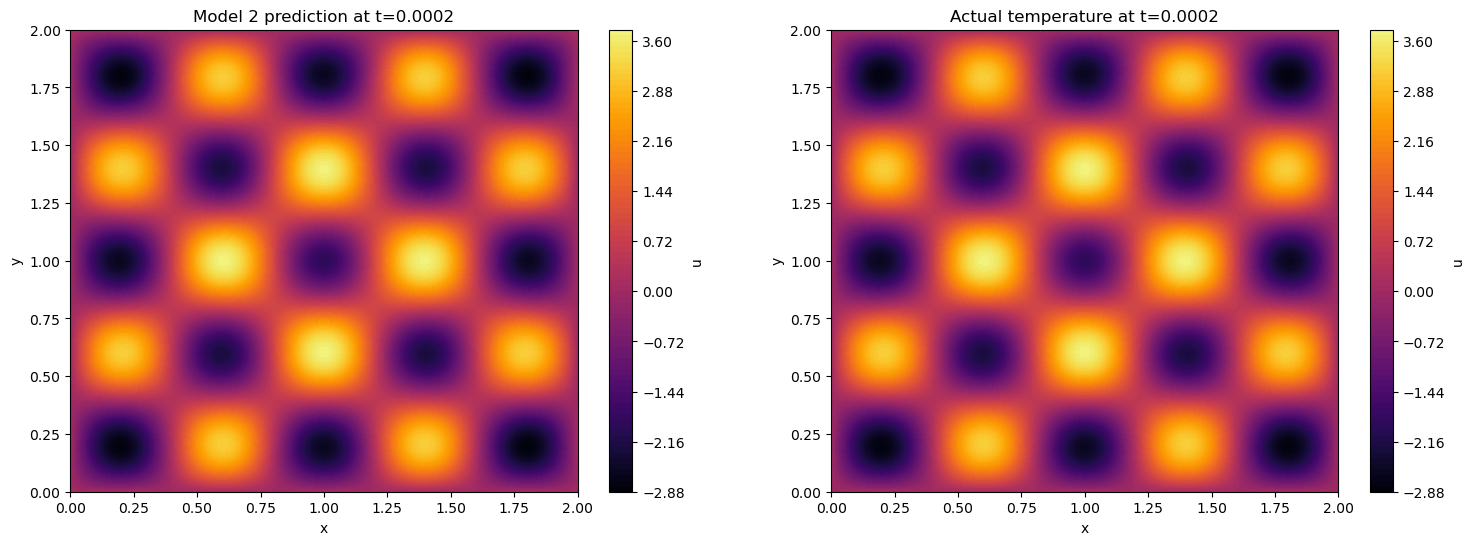

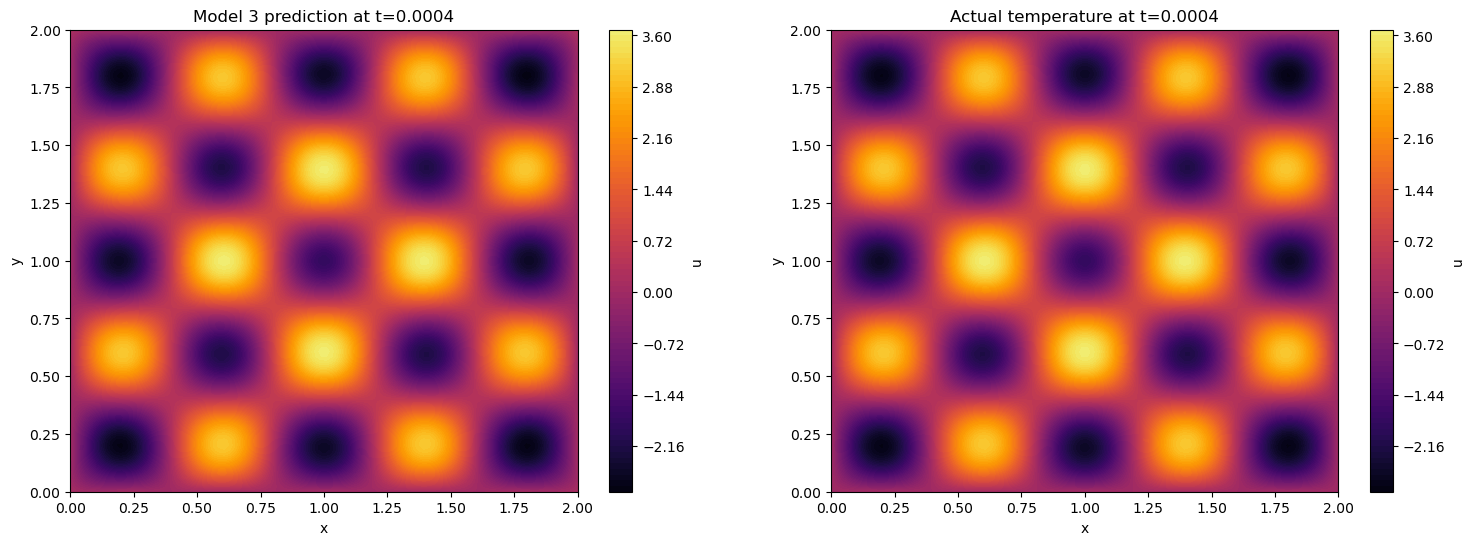

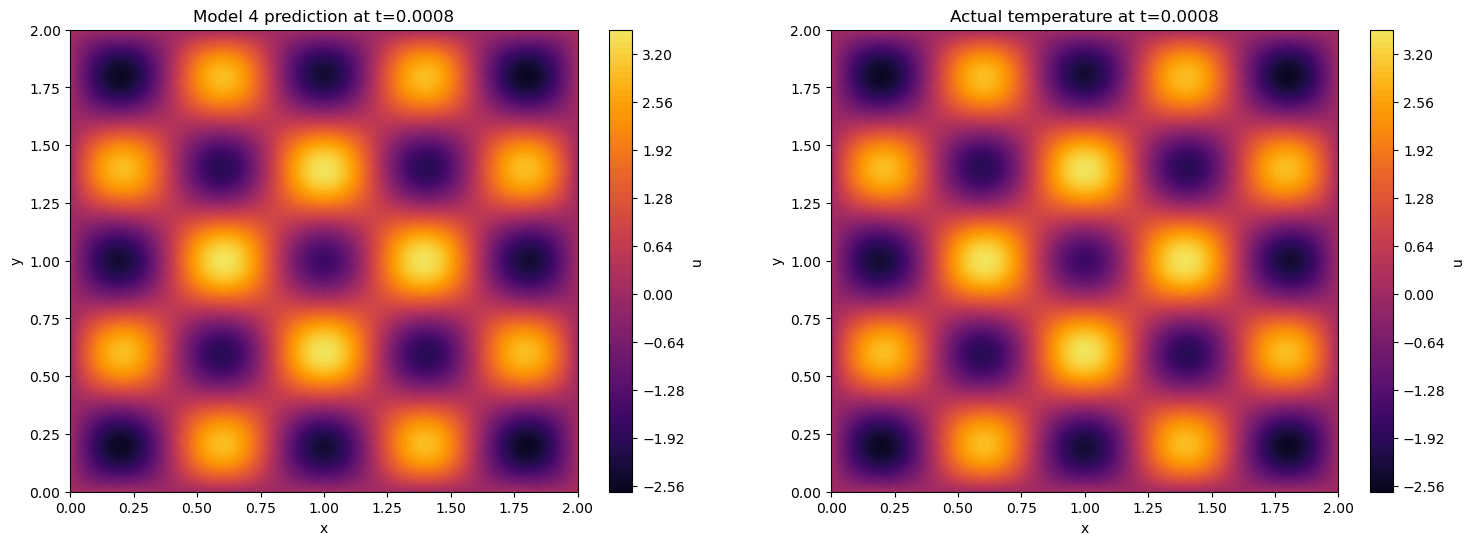

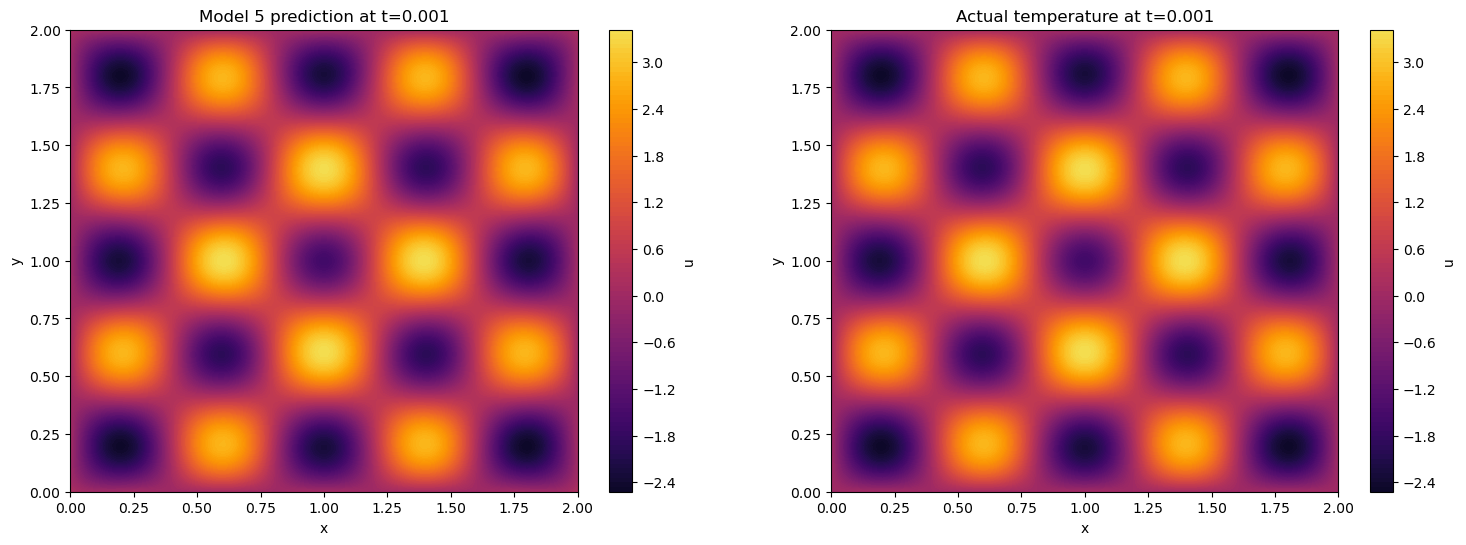

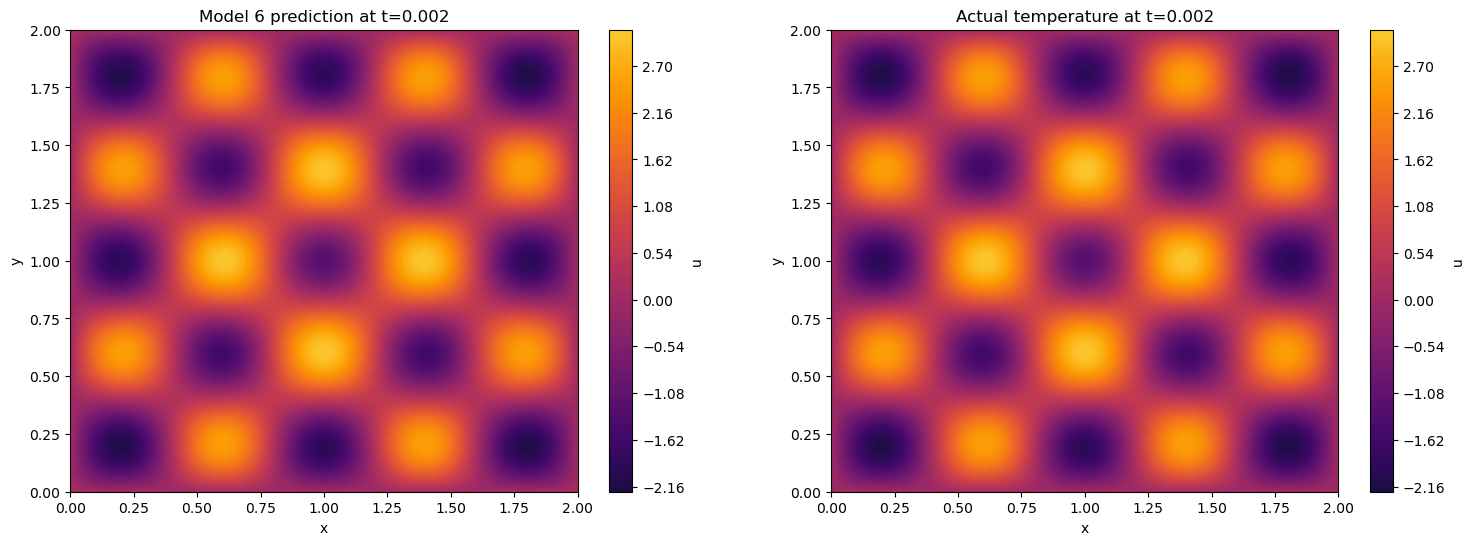

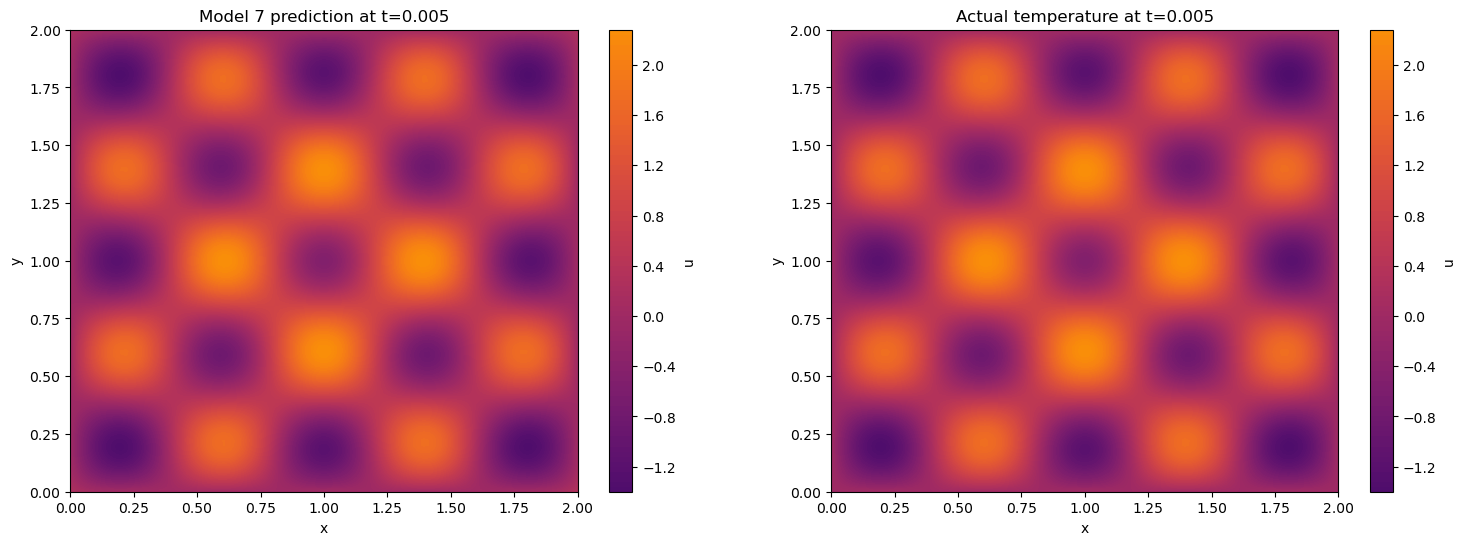

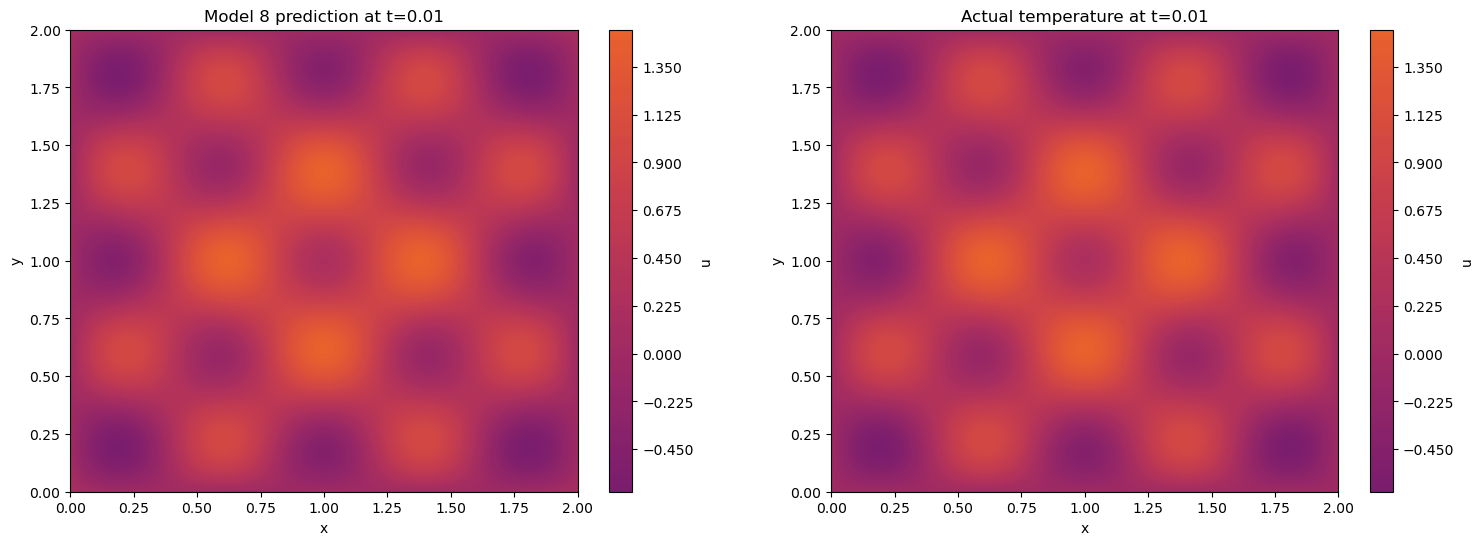

In [13]:
time_stamps = [time[1] for time in model_time_dict.values()]
plot_ctx.figsize = (18, 6)

for i, model in enumerate(model_time_dict.keys()):
    plot_ctx.titles = [f'Model {i + 1} prediction at t={time_stamps[i]}', f'Actual temperature at t={time_stamps[i]}']
    plot_ctx.function_names = ['u', 'u']
    utils.plot_function_on_2d_cube([lambda x: model(torch.cat([x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1)),
                                    lambda x: analytical_solution(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1))],
                                    plot_ctx=plot_ctx)

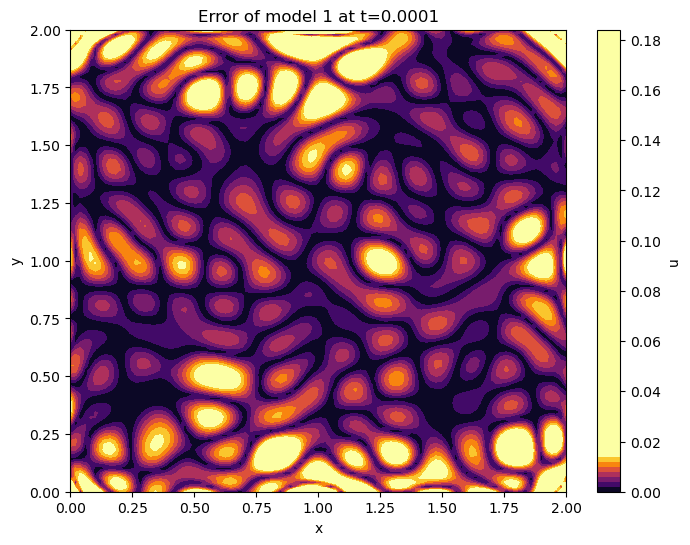

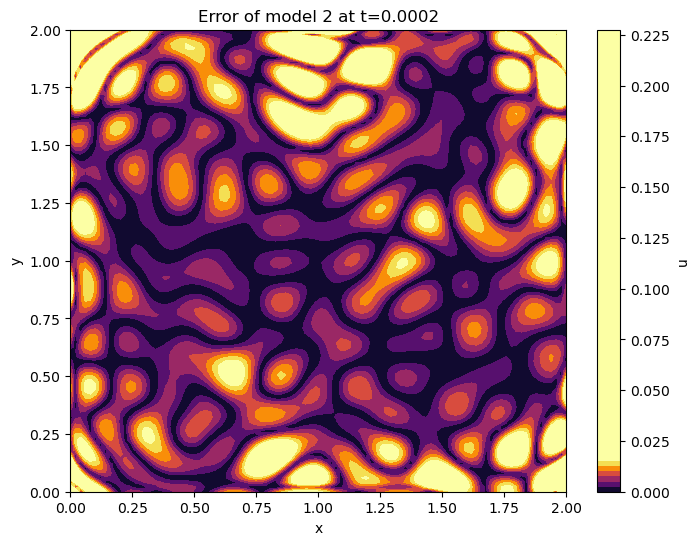

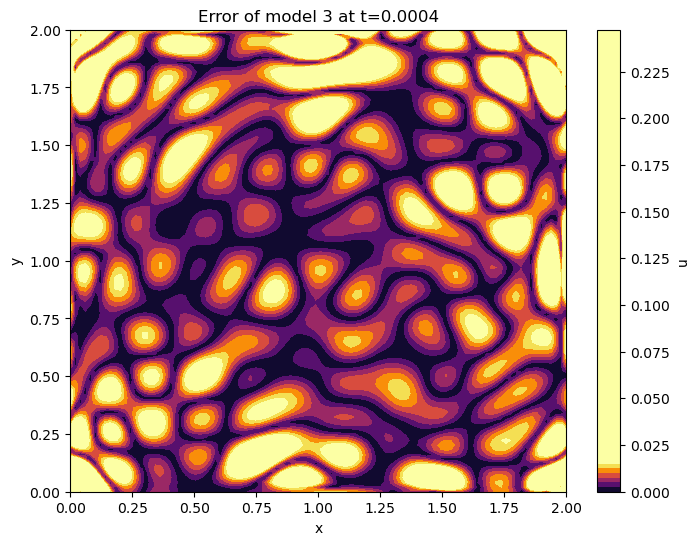

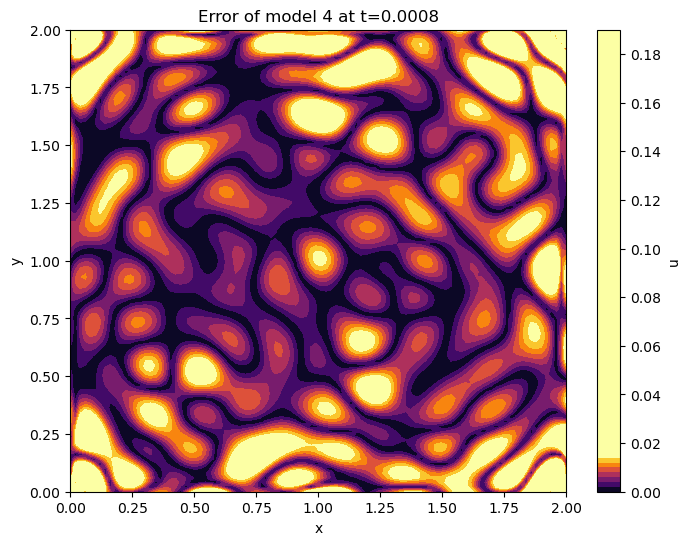

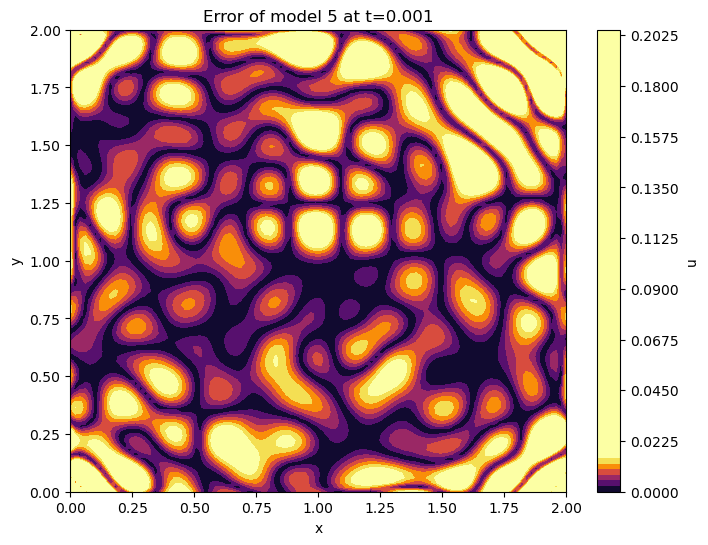

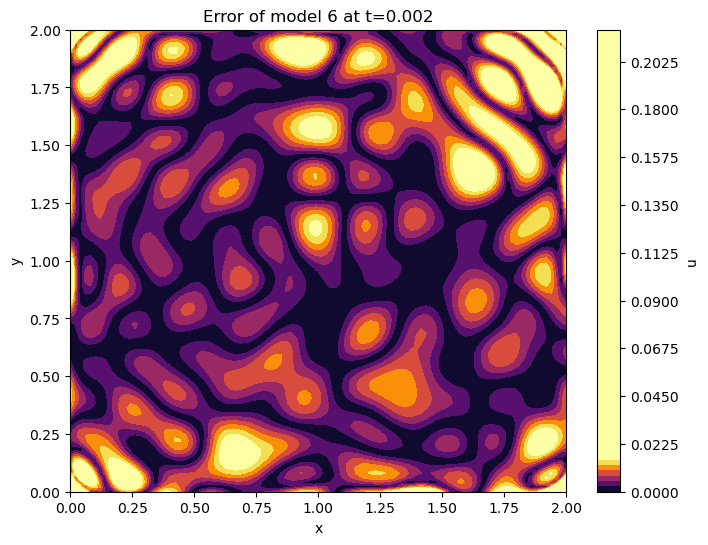

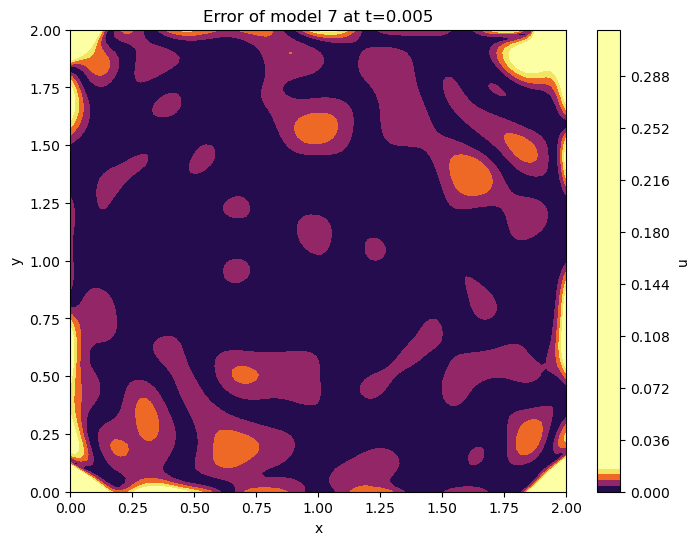

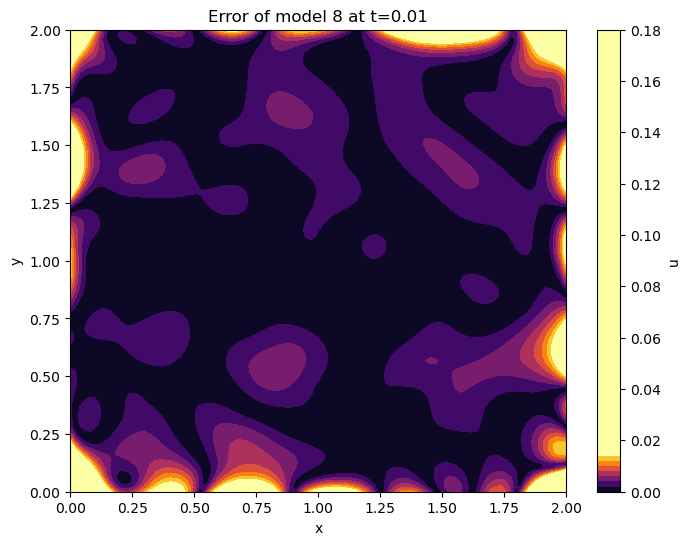

In [19]:
time_stamps = [time[1] for time in model_time_dict.values()]
plot_ctx.figsize = (8, 6)
plot_ctx.vmin = 0.0
plot_ctx.vmax = 0.015

for i, model in enumerate(model_time_dict.keys()):
    plot_ctx.titles = [f'Error of model {i + 1} at t={time_stamps[i]}']
    plot_ctx.function_names = ['u', 'u']
    utils.plot_function_on_2d_cube([lambda x: torch.abs(model(torch.cat([x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1)) -\
                                    analytical_solution(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1)))],
                                    plot_ctx=plot_ctx)

In [14]:
# A spocteme L2 chybu
torch.cuda.empty_cache()
l2_error = 0


for i, (model, time) in enumerate(model_time_dict.items()):
    partial_l2_error = calc.L2_norm(analytical_solution, model, 3, [2, 2, time[1]], [0, 0, time[0]], device=device, n=20)**2
    l2_error += partial_l2_error
    print(f'L2 chyba modelu {i + 1} je {torch.sqrt(partial_l2_error)}')

print(f"Celkova L2 chyba reseni je {torch.sqrt(l2_error)}")

L2 chyba modelu 1 je 0.00015446808538399637
L2 chyba modelu 2 je 0.0002032981428783387
L2 chyba modelu 3 je 0.0003577320894692093
L2 chyba modelu 4 je 0.0004296231782063842
L2 chyba modelu 5 je 0.0003652602608781308
L2 chyba modelu 6 je 0.0006427658954635262
L2 chyba modelu 7 je 0.0009508224320597947
L2 chyba modelu 8 je 0.0007821533945389092
Celkova L2 chyba reseni je 0.00156209128908813
